Operations performed:

1. Drop irrelevant columns
2. Handled missing/null values
3. Remove duplicates
4. Plot boxplot for all weather indices (min, max, mean and variance)
5. Remove outliers from all weather indices (min, max, mean and variance)
6. Plot boxplot for all weather indices after outlier removal (min, max, mean and variance)
7. Plot region based distribution for all weather indices (min, max, mean and variance)
8. Drop 'Region' column
9. Perform PCA on weather attributes (Precipitation, Relativehumidity, SoilWaterContent, SolarRadiation, Temperature, WindSpeed)
10. Drop 'Date' column

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/dataset1.csv', parse_dates=['Date'])
df.head()
df = df.rename(columns={
    'Vegetation_index_max': 'Vegetation_Index_max',
    'Vegetation_index_min': 'Vegetation_Index_min',
    'Vegetation_index_mean': 'Vegetation_Index_mean',
    'Vegetation_index_variance': 'Vegetation_Index_variance',

})

In [ ]:
df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,...,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance,Vegetation_Index_mean,Vegetation_Index_max,Vegetation_Index_min,Vegetation_index_std,Vegetation_Index_variance
0,NSW,2005-04-01,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,...,9.455474,7.364222,4.841764,1.401951,1.494301,NaN,NaN,NaN,NaN,NaN
1,NSW,2005-05-01,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,...,13.352380,7.091141,4.014080,1.011328,1.043316,NaN,NaN,NaN,NaN,NaN
2,NSW,2005-06-01,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,...,11.764178,9.905821,4.477879,0.930842,1.953685,NaN,NaN,NaN,NaN,NaN
3,NSW,2005-07-01,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,...,7.940373,10.446799,4.017578,1.601724,1.102751,NaN,NaN,NaN,NaN,NaN
4,NSW,2005-08-01,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,...,12.063971,6.671862,3.884550,1.167861,0.774612,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(26740, 39)

(26740, 39)

In [ ]:
df.drop_duplicates(inplace=True)
df.drop('Mean_confidence', axis=1, inplace=True)
df.drop('Std_confidence', axis=1, inplace=True)
df.drop('Var_confidence', axis=1, inplace=True)
df.drop('Count', axis=1, inplace=True)
df.drop('Replaced', axis=1, inplace=True)
df.drop('Vegetation_index_std', axis=1, inplace=True)
df.drop('Vegetation_Index_max', axis=1, inplace=True)
df.drop('Vegetation_Index_min', axis=1, inplace=True)
df.drop('Vegetation_Index_mean', axis=1, inplace=True)
df.drop('Vegetation_Index_variance', axis=1, inplace=True)

In [ ]:
missing_columns = df.columns[df.isnull().any()].tolist()
print(missing_columns)
print(df.isnull().sum())
print(df.isna().sum())

['Precipitation_Max', 'Precipitation_Mean', 'Precipitation_Min', 'Precipitation_Variance', 'RelativeHumidity_Max', 'RelativeHumidity_Mean', 'RelativeHumidity_Min', 'RelativeHumidity_Variance', 'SoilWaterContent_Max', 'SoilWaterContent_Mean', 'SoilWaterContent_Min', 'SoilWaterContent_Variance', 'SolarRadiation_Max', 'SolarRadiation_Mean', 'SolarRadiation_Min', 'SolarRadiation_Variance', 'Temperature_Max', 'Temperature_Mean', 'Temperature_Min', 'Temperature_Variance', 'WindSpeed_Max', 'WindSpeed_Mean', 'WindSpeed_Min', 'WindSpeed_Variance']
Region                                  0
Date                                    0
Estimated_fire_area                     0
Mean_estimated_fire_brightness          0
Mean_estimated_fire_radiative_power     0
Precipitation_Max                      39
Precipitation_Mean                     39
Precipitation_Min                      39
Precipitation_Variance                 39
RelativeHumidity_Max                   62
RelativeHumidity_Mean              

In [ ]:
# Iterate through the columns with missing values
indices_to_drop = []

for col in missing_columns:
    datatype = df[col].dtype
    print(col)
    if datatype == 'float64' or datatype == 'int64':
        prefixes = set(col.rsplit('_', 1)[0] for col in df.columns if '_Mean' in col or '_Max' in col or '_Min' in col)

        for prefix in prefixes:
            mean_col = f"{prefix}_Mean"
            max_col = f"{prefix}_Max"
            min_col = f"{prefix}_Min"

            for index, row in df.iterrows():
                # If all values are missing
                if pd.isnull(row[mean_col]) and pd.isnull(row[max_col]) and pd.isnull(row[min_col]):
                        indices_to_drop.append(index)

                # If only mean is missing
                elif pd.isnull(row[mean_col]) and not pd.isnull(row[max_col]) and not pd.isnull(row[min_col]):
                    df.at[index, mean_col] = (row[max_col] + row[min_col]) / 2

                # If only max is missing
                elif pd.isnull(row[max_col]) and not pd.isnull(row[mean_col]) and not pd.isnull(row[min_col]):
                    df.at[index, max_col] = 2*row[mean_col] - row[min_col]

                # If only min is missing
                elif pd.isnull(row[min_col]) and not pd.isnull(row[mean_col]) and not pd.isnull(row[max_col]):
                    df.at[index, min_col] = 2*row[mean_col] - row[max_col]

                # If max and min are missing
                elif pd.isnull(row[max_col]) and pd.isnull(row[min_col]):
                    df.at[index, max_col] = df[max_col].mean()
                    df.at[index, min_col] = df[min_col].mean()

                # If max and mean are missing
                elif pd.isnull(row[max_col]) and pd.isnull(row[mean_col]):
                    df.at[index, max_col] = df[max_col].mean()
                    df.at[index, mean_col] = (df.at[index, max_col] + row[min_col]) / 2

                # If min and mean are missing
                elif pd.isnull(row[max_col]) and pd.isnull(row[mean_col]):
                    df.at[index, min_col] = df[min_col].mean()
                    df.at[index, mean_col] = (df.at[index, max_col] + row[min_col]) / 2

        else:
            df[col].fillna(df[col].mean(), inplace=True)
    elif datatype == 'object':
        # Categorical columns
        df[col].fillna(df[col].mode()[0], inplace=True)

df.drop(indices_to_drop, inplace=True)

Precipitation_Max
Precipitation_Mean
Precipitation_Min
Precipitation_Variance
RelativeHumidity_Max
RelativeHumidity_Mean
RelativeHumidity_Min
RelativeHumidity_Variance
SoilWaterContent_Max
SoilWaterContent_Mean
SoilWaterContent_Min
SoilWaterContent_Variance
SolarRadiation_Max
SolarRadiation_Mean
SolarRadiation_Min
SolarRadiation_Variance
Temperature_Max
Temperature_Mean
Temperature_Min
Temperature_Variance
WindSpeed_Max
WindSpeed_Mean
WindSpeed_Min
WindSpeed_Variance


In [ ]:
print(df.isnull().sum())
print(df.isna().sum())

Region                                 0
Date                                   0
Estimated_fire_area                    0
Mean_estimated_fire_brightness         0
Mean_estimated_fire_radiative_power    0
Precipitation_Max                      0
Precipitation_Mean                     0
Precipitation_Min                      0
Precipitation_Variance                 0
RelativeHumidity_Max                   0
RelativeHumidity_Mean                  0
RelativeHumidity_Min                   0
RelativeHumidity_Variance              0
SoilWaterContent_Max                   0
SoilWaterContent_Mean                  0
SoilWaterContent_Min                   0
SoilWaterContent_Variance              0
SolarRadiation_Max                     0
SolarRadiation_Mean                    0
SolarRadiation_Min                     0
SolarRadiation_Variance                0
Temperature_Max                        0
Temperature_Mean                       0
Temperature_Min                        0
Temperature_Vari

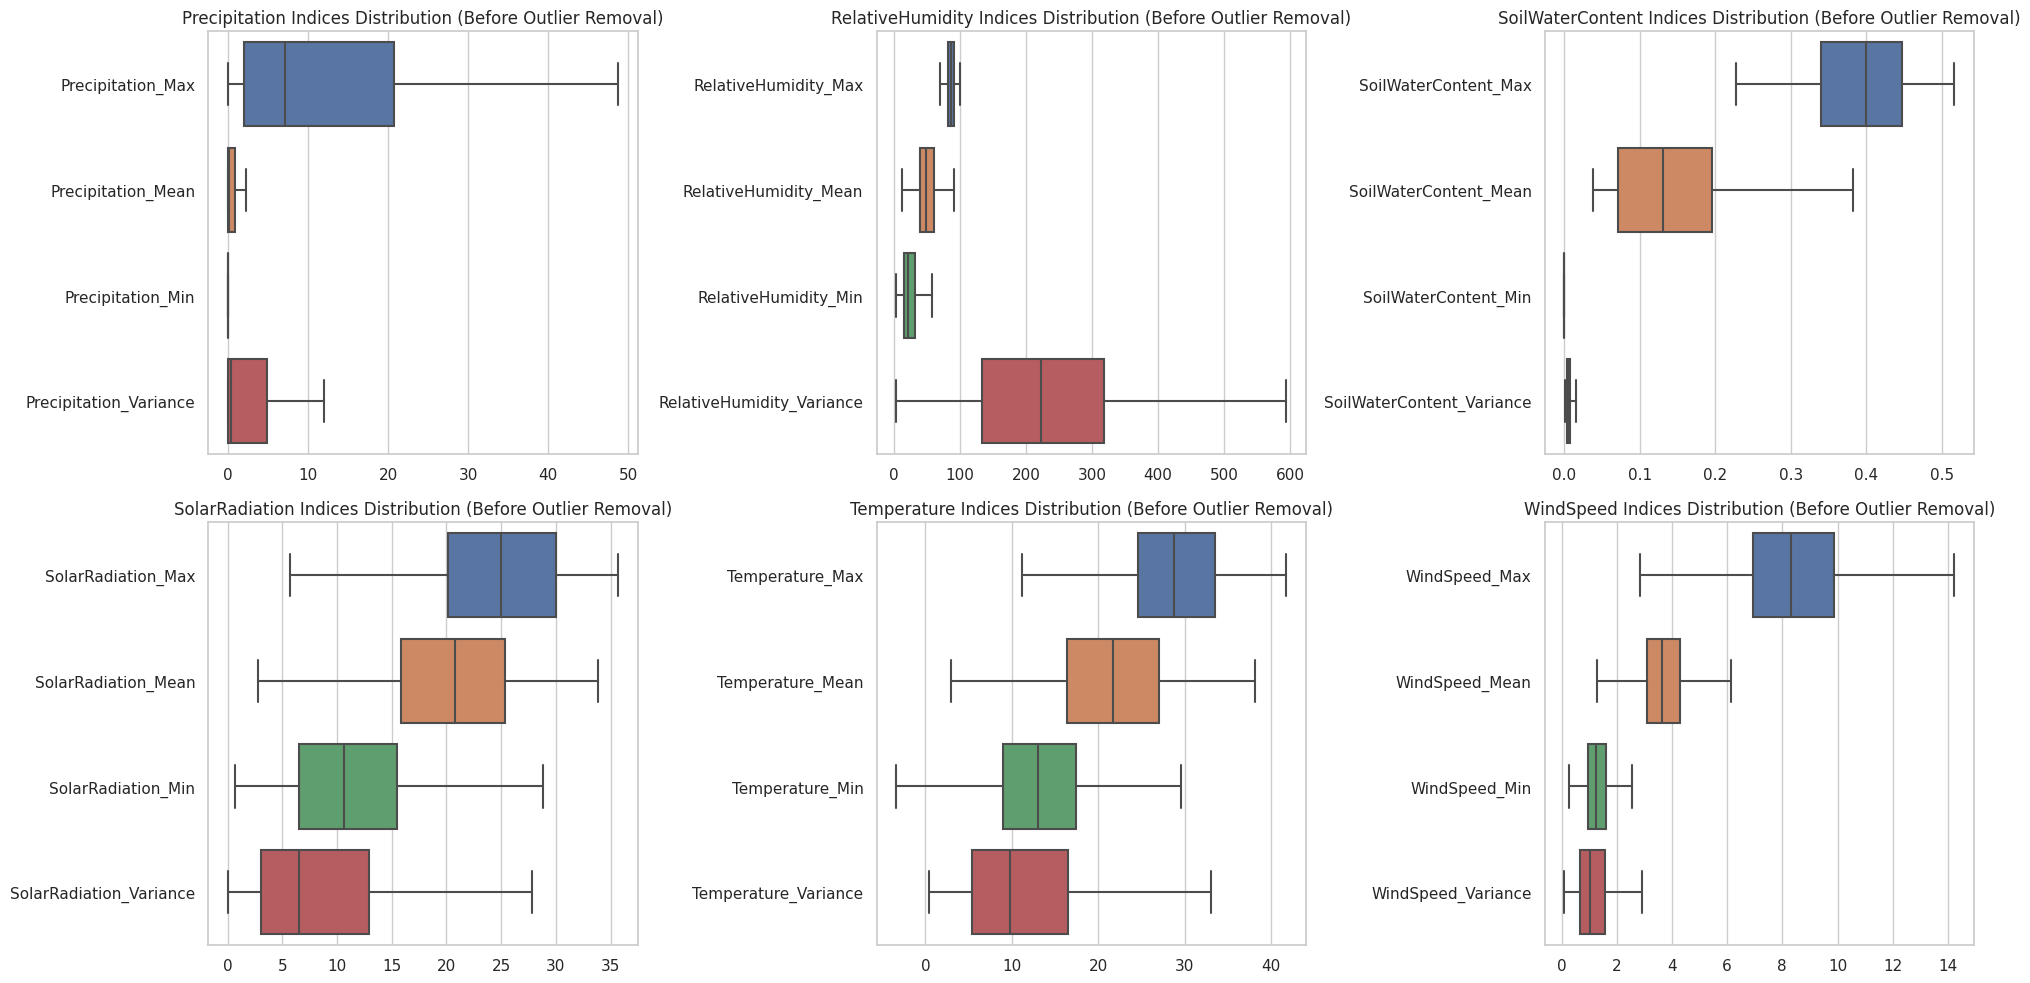

In [ ]:
# Define the list of attributes and metrics
attributes = ['Precipitation', 'RelativeHumidity', 'SoilWaterContent', 'SolarRadiation', 'Temperature', 'WindSpeed']
metrics = ['_Max', '_Mean', '_Min', '_Variance']

# Set the sns style
sns.set(style="whitegrid")

# Create a subplot layout for boxplots
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))

for i, attr in enumerate(attributes):
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Get the columns corresponding to the current attribute
    cols_to_plot = [f"{attr}{metric}" for metric in metrics]
    cols_to_plot = [col for col in cols_to_plot if col in df.columns]

    if cols_to_plot:  # Only plot if there are valid columns to plot
        data_to_plot = df[cols_to_plot]
        # Plot the boxplot
        sns.boxplot(data=data_to_plot, ax=axes[row_idx, col_idx], orient='h', showfliers=False)
        axes[row_idx, col_idx].set_title(f"{attr} Indices Distribution (Before Outlier Removal)")

plt.tight_layout()
plt.show()


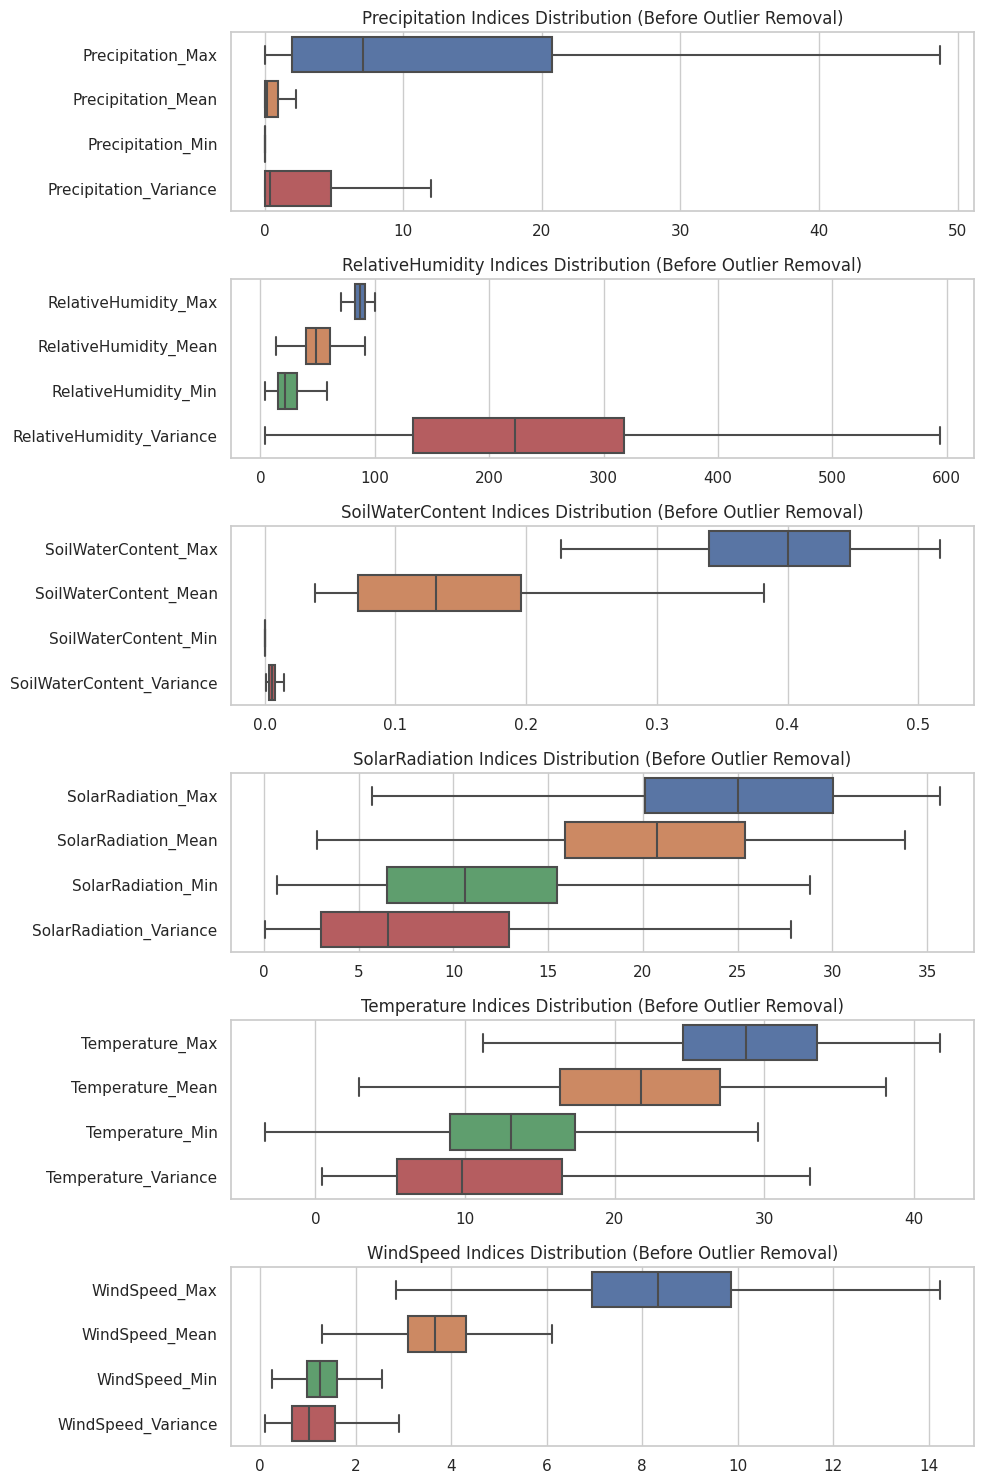

In [ ]:
# Define the list of attributes and metrics
attributes = ['Precipitation', 'RelativeHumidity', 'SoilWaterContent', 'SolarRadiation', 'Temperature', 'WindSpeed']
metrics = ['_Max', '_Mean', '_Min', '_Variance']

# Set the sns style
sns.set(style="whitegrid")

# Create a subplot layout for boxplots
fig, axes = plt.subplots(nrows=len(attributes), figsize=(10, 15))

for i, attr in enumerate(attributes):
    # Get the columns corresponding to the current attribute
    cols_to_plot = [f"{attr}{metric}" for metric in metrics]
    cols_to_plot = [col for col in cols_to_plot if col in df.columns]

    if cols_to_plot:  # Only plot if there are valid columns to plot
        data_to_plot = df[cols_to_plot]
        # Plot the boxplot
        sns.boxplot(data=data_to_plot, ax=axes[i], orient='h', showfliers=False)
        axes[i].set_title(f"{attr} Indices Distribution (Before Outlier Removal)")

plt.tight_layout()
plt.show()

Since the data is a trend, performing oultier removal deletes significant amount of information from the dataset.

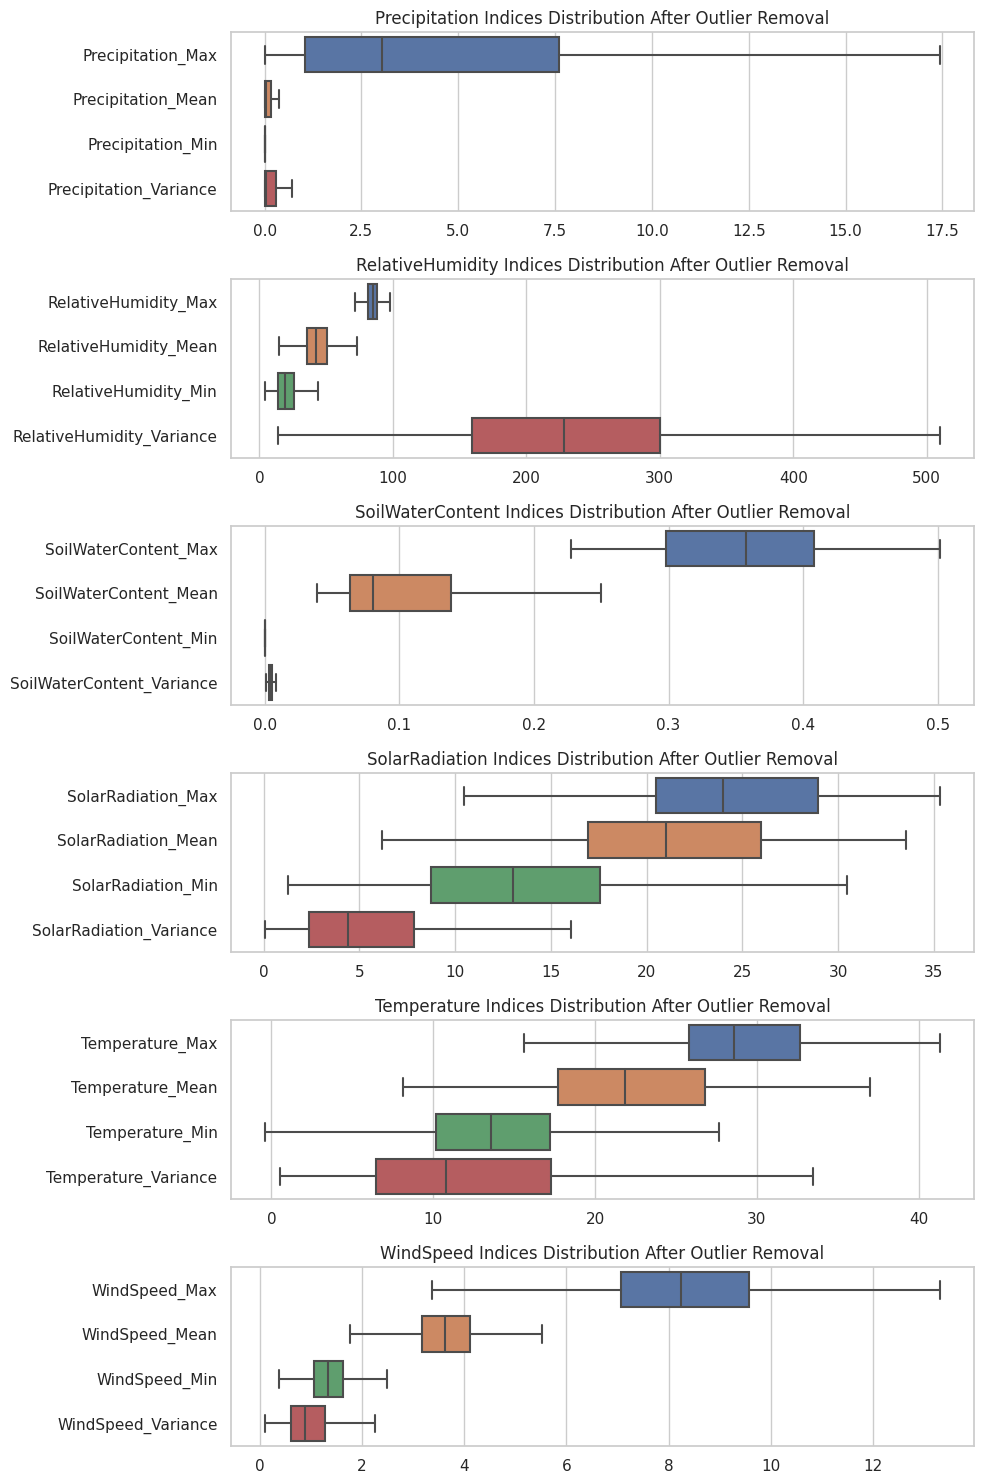

In [ ]:
attributes = ['Precipitation', 'RelativeHumidity', 'SoilWaterContent', 'SolarRadiation', 'Temperature', 'WindSpeed']

for attr in attributes:
    for metric in ['_Max', '_Mean', '_Min', '_Variance']:
        col = f"{attr}{metric}"

        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# After filtering, you can regenerate the boxplots
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=len(attributes), figsize=(10, 15))

for i, attr in enumerate(attributes):
    cols_to_plot = [col for col in df.columns if attr in col]
    data_to_plot = df[cols_to_plot]

    # Plot the boxplot
    sns.boxplot(data=data_to_plot, ax=axes[i], orient='h', showfliers=False)
    axes[i].set_title(f"{attr} Indices Distribution After Outlier Removal")

plt.tight_layout()
plt.show()

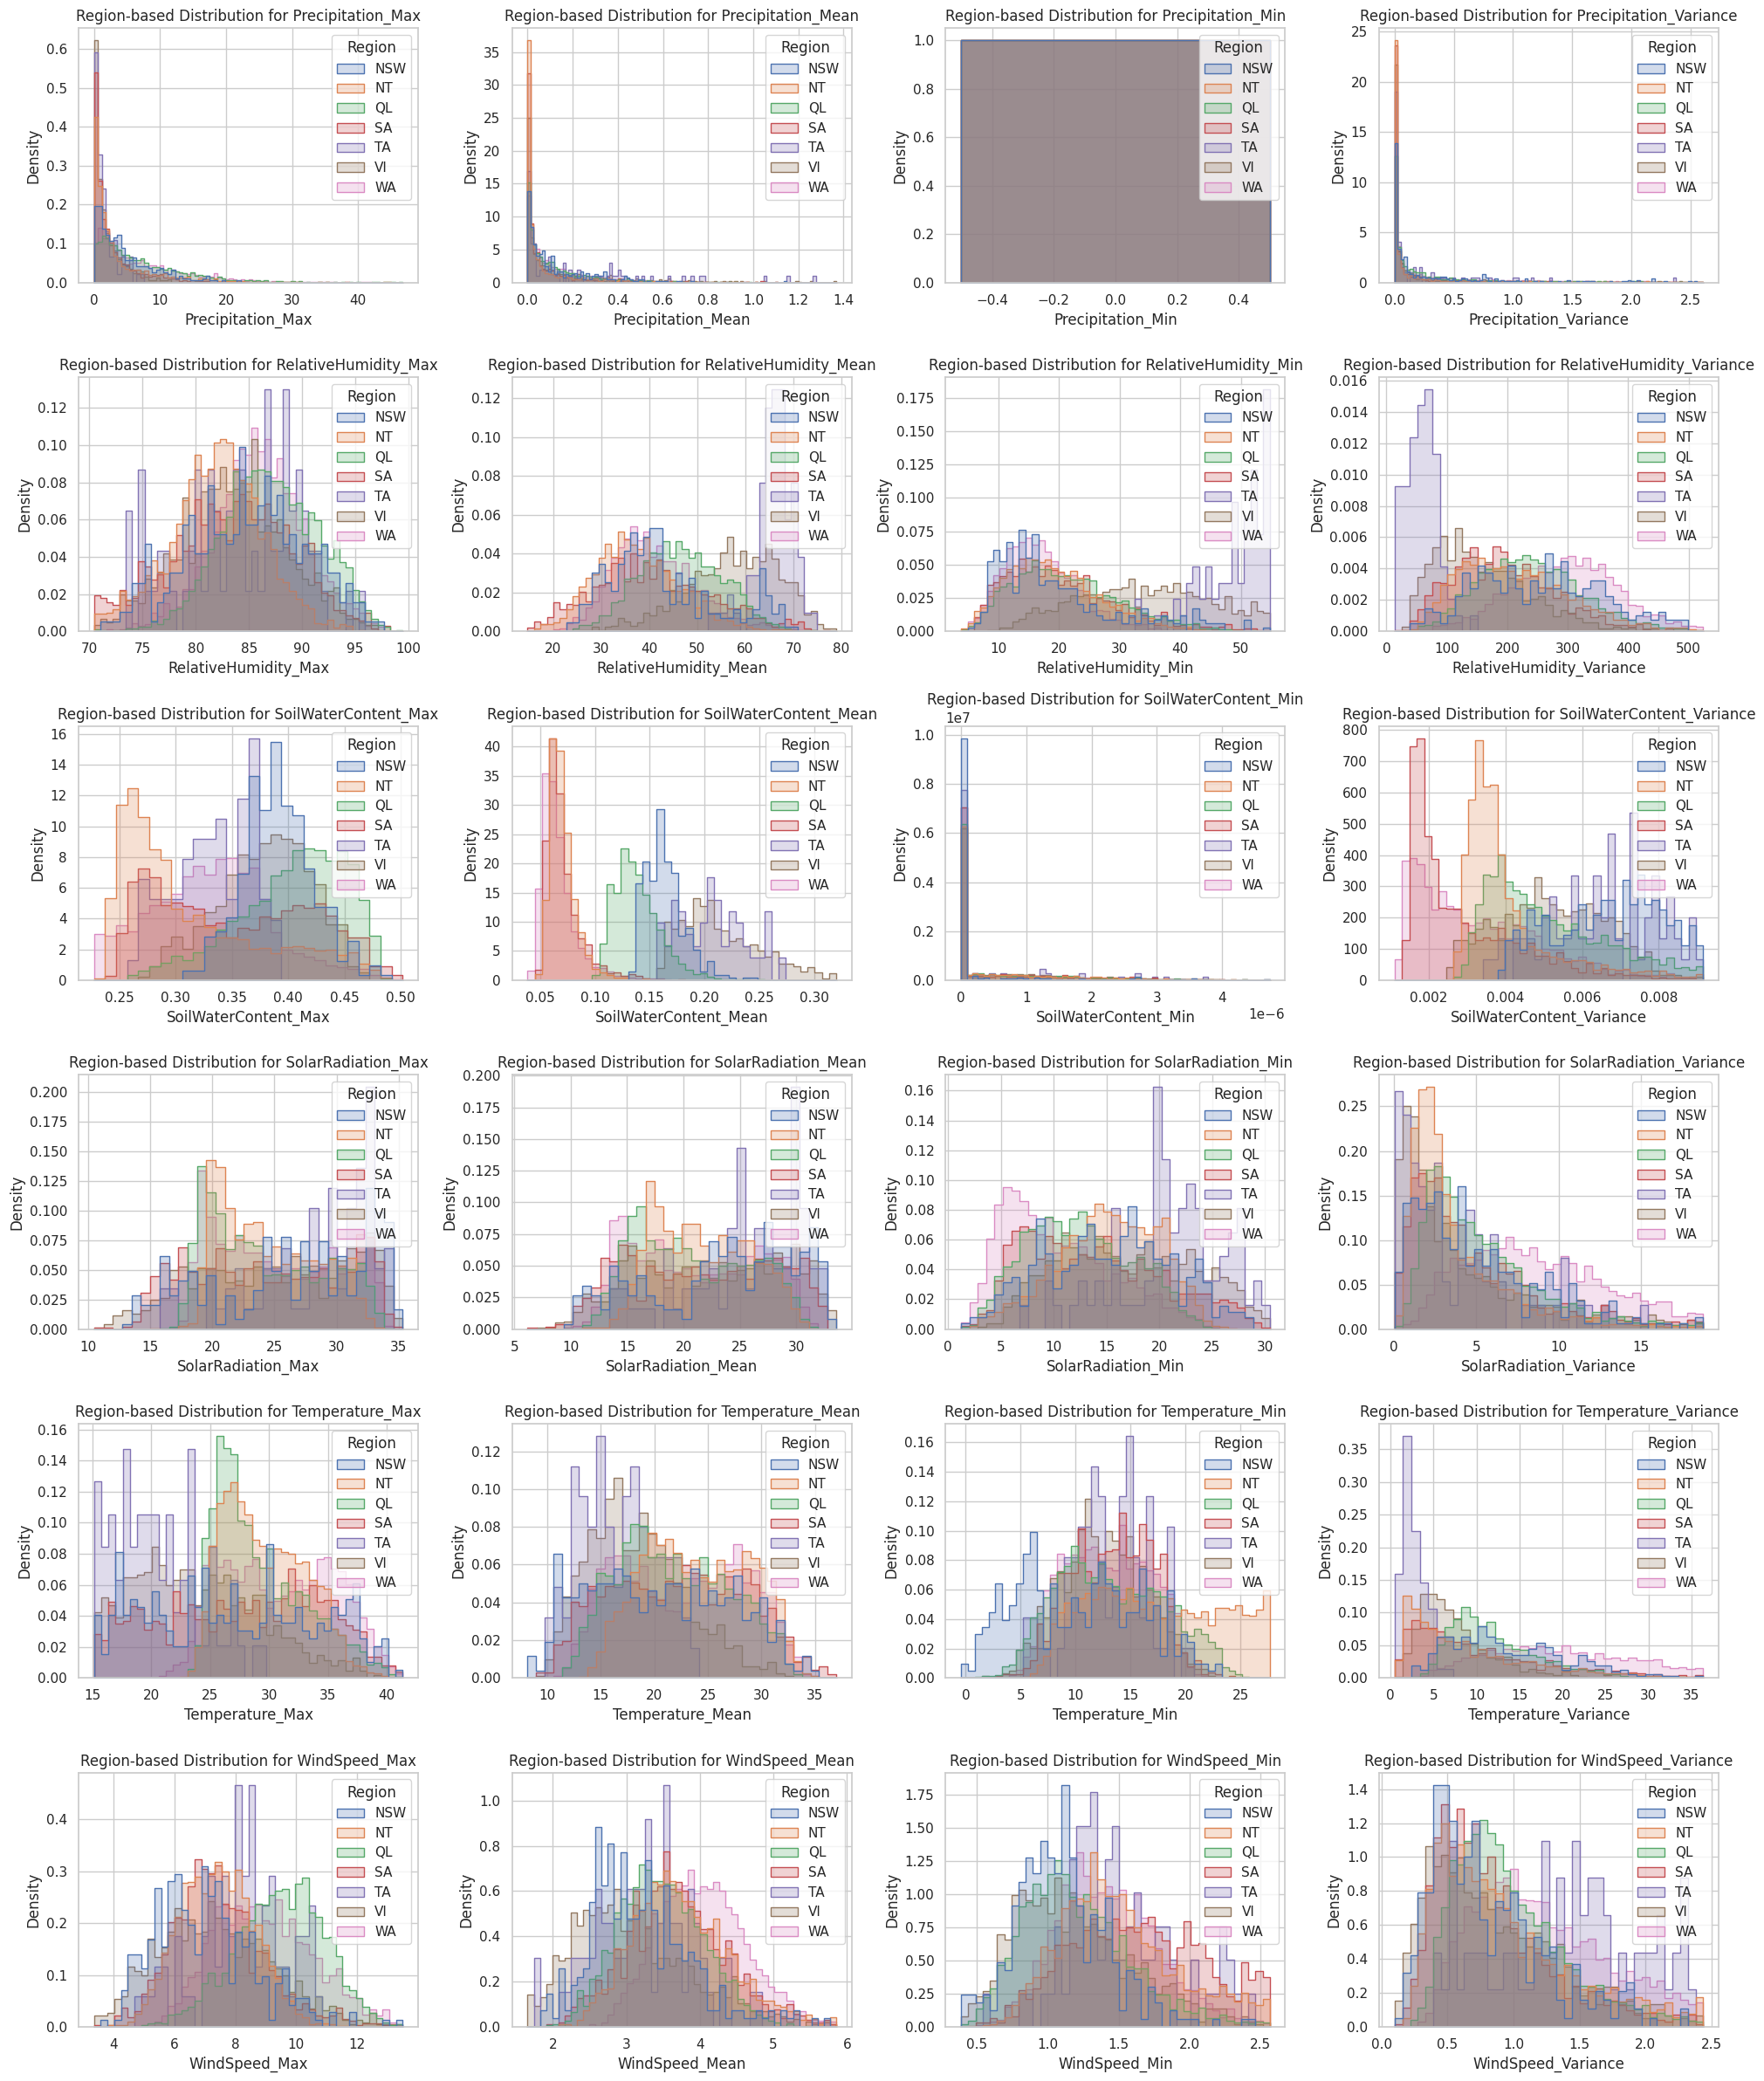

In [ ]:
# Region Distribution
attributes_for_boxplot = [
    'Precipitation_Max', 'Precipitation_Mean', 'Precipitation_Min', 'Precipitation_Variance',
    'RelativeHumidity_Max', 'RelativeHumidity_Mean', 'RelativeHumidity_Min', 'RelativeHumidity_Variance',
    'SoilWaterContent_Max', 'SoilWaterContent_Mean', 'SoilWaterContent_Min', 'SoilWaterContent_Variance',
    'SolarRadiation_Max', 'SolarRadiation_Mean', 'SolarRadiation_Min', 'SolarRadiation_Variance',
    'Temperature_Max', 'Temperature_Mean', 'Temperature_Min', 'Temperature_Variance',
    'WindSpeed_Max', 'WindSpeed_Mean', 'WindSpeed_Min', 'WindSpeed_Variance'
]

# Set up a grid of plots
num_rows = 6
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 24))

# Flatten the axes to make it easier to iterate over
axes = axes.ravel()

# Plot each attribute on its own subplot
for i, col in enumerate(attributes_for_boxplot):
    sns.histplot(data=df, x=col, hue="Region", element="step", stat="density", common_norm=False, ax=axes[i])
    axes[i].set_title(f"Region-based Distribution for {col}")

# If there are more subplots than attributes, turn off the remaining ones
for j in range(len(attributes_for_boxplot), num_rows*num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Region based distribution
# attributes_for_boxplot = ['Precipitation_Max', 'Precipitation_Mean', 'Precipitation_Min', 'Precipitation_Variance',
#                           'RelativeHumidity_Max', 'RelativeHumidity_Mean', 'RelativeHumidity_Min', 'RelativeHumidity_Variance',
#                           'SoilWaterContent_Max', 'SoilWaterContent_Mean', 'SoilWaterContent_Min', 'SoilWaterContent_Variance',
#                           'SolarRadiation_Max', 'SolarRadiation_Mean', 'SolarRadiation_Min', 'SolarRadiation_Variance',
#                           'Temperature_Max', 'Temperature_Mean', 'Temperature_Min', 'Temperature_Variance',
#                           'WindSpeed_Max', 'WindSpeed_Mean', 'WindSpeed_Min', 'WindSpeed_Variance'
#                           ]
# for col in attributes_for_boxplot:
#     plt.figure(figsize=(10,6))
#     sns.histplot(data=df, x=col, hue="Region", element="step", stat="density", common_norm=False)
#     plt.title(f"Region-based Distribution for {col}")
#     plt.show()


In [ ]:
df.shape

(11019, 29)

In [ ]:
df.columns

Index(['Region', 'Date', 'Estimated_fire_area',
       'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power',
       'Precipitation_Max', 'Precipitation_Mean', 'Precipitation_Min',
       'Precipitation_Variance', 'RelativeHumidity_Max',
       'RelativeHumidity_Mean', 'RelativeHumidity_Min',
       'RelativeHumidity_Variance', 'SoilWaterContent_Max',
       'SoilWaterContent_Mean', 'SoilWaterContent_Min',
       'SoilWaterContent_Variance', 'SolarRadiation_Max',
       'SolarRadiation_Mean', 'SolarRadiation_Min', 'SolarRadiation_Variance',
       'Temperature_Max', 'Temperature_Mean', 'Temperature_Min',
       'Temperature_Variance', 'WindSpeed_Max', 'WindSpeed_Mean',
       'WindSpeed_Min', 'WindSpeed_Variance'],
      dtype='object')

In [ ]:
# Drop the 'Region' column after encoding
# df.drop('Region', axis=1, inplace=True)

In [ ]:
# print(df.isnull().sum())
# print(df.isna().sum())

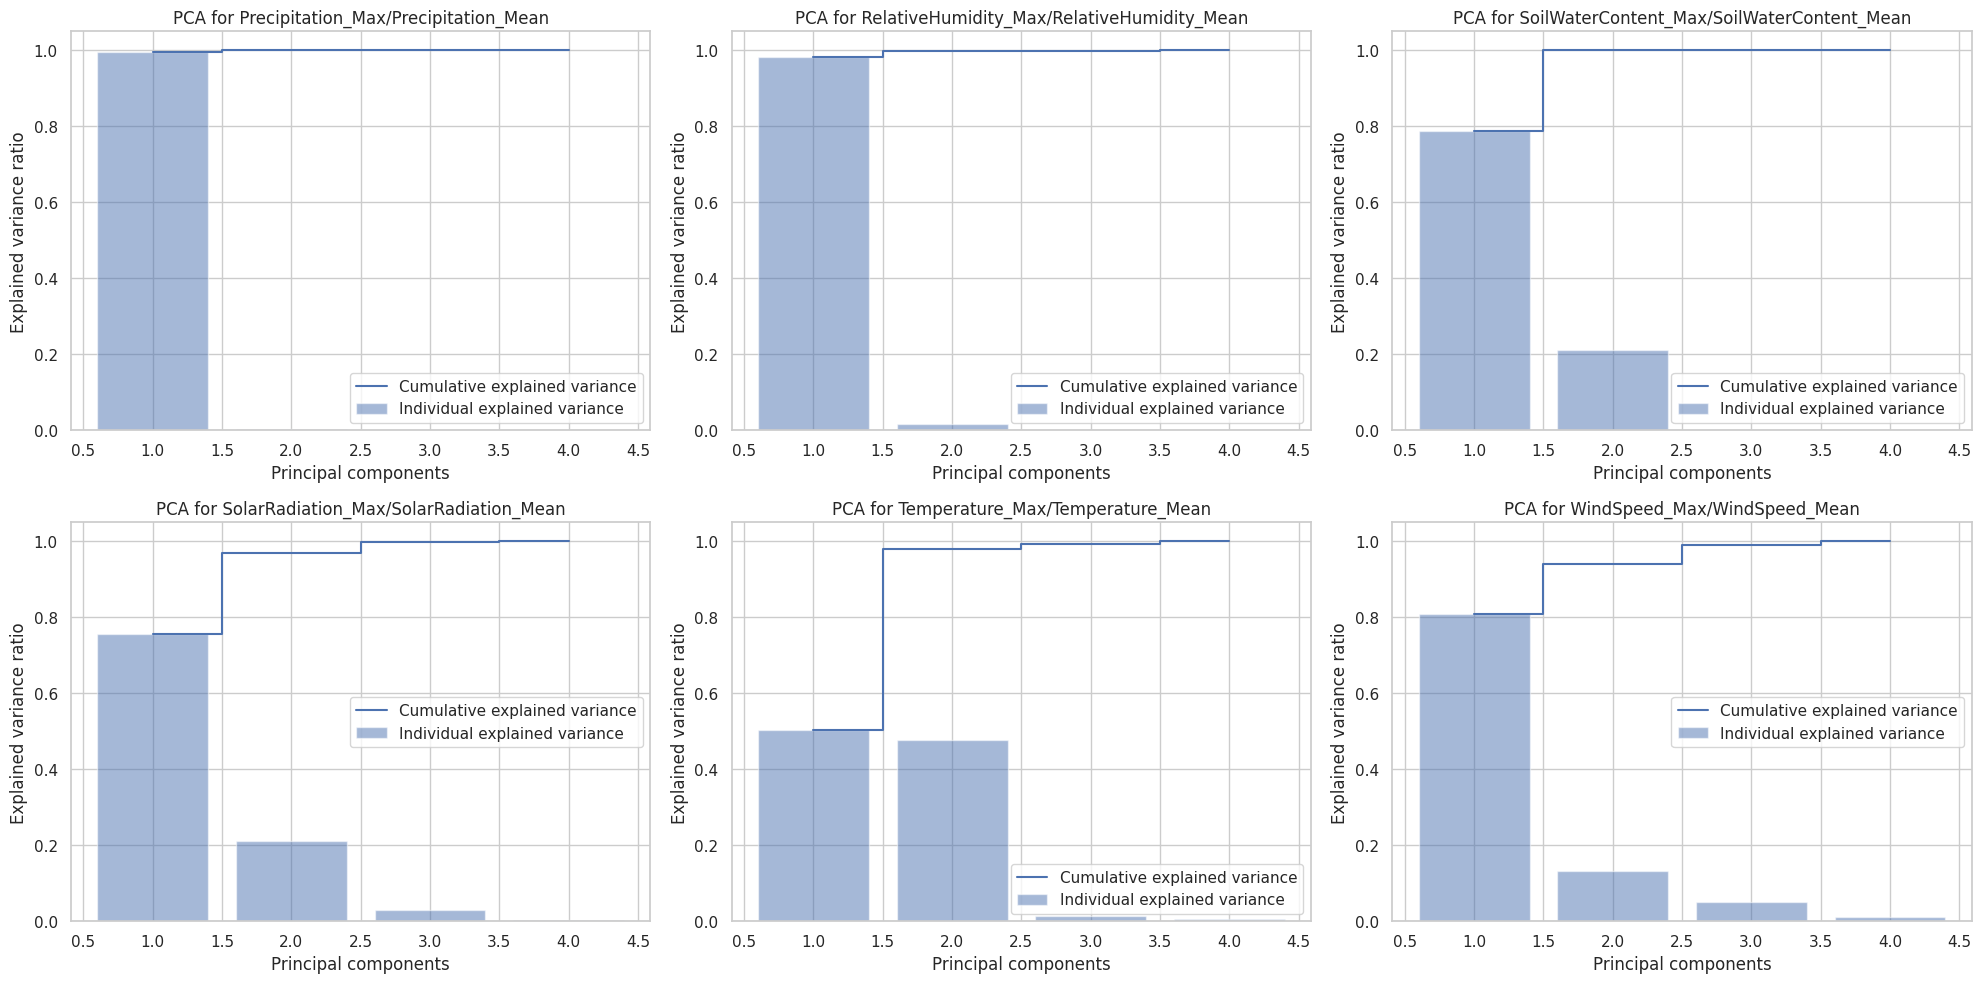

In [ ]:
# List of attribute groups
attribute_groups = [
    ['Precipitation_Max', 'Precipitation_Mean', 'Precipitation_Min', 'Precipitation_Variance'],
    ['RelativeHumidity_Max', 'RelativeHumidity_Mean', 'RelativeHumidity_Min', 'RelativeHumidity_Variance'],
    ['SoilWaterContent_Max', 'SoilWaterContent_Mean', 'SoilWaterContent_Min', 'SoilWaterContent_Variance'],
    ['SolarRadiation_Max', 'SolarRadiation_Mean', 'SolarRadiation_Min', 'SolarRadiation_Variance'],
    ['Temperature_Max', 'Temperature_Mean', 'Temperature_Min', 'Temperature_Variance'],
    ['WindSpeed_Max', 'WindSpeed_Mean', 'WindSpeed_Min', 'WindSpeed_Variance']
]

# Set up a grid of plots
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Flatten the axes to make it easier to iterate over
axes = axes.ravel()

pca = PCA()

# Apply PCA and plot for each attribute group
for i, group in enumerate(attribute_groups):
    pca.fit(df[group])
    explained_var = pca.explained_variance_ratio_

    axes[i].bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    axes[i].step(range(1, len(explained_var) + 1), explained_var.cumsum(), where='mid', label='Cumulative explained variance')
    axes[i].set_ylabel('Explained variance ratio')
    axes[i].set_xlabel('Principal components')
    axes[i].legend(loc='best')
    axes[i].set_title(f"PCA for {'/'.join(group[:2])}")

plt.tight_layout()
plt.show()


In [ ]:
attributes = ['Precipitation', 'RelativeHumidity', 'SoilWaterContent']

# Initialize PCA and Scaler
pca = PCA(n_components=2)
scaler = StandardScaler()

# List of columns to drop after PCA
cols_to_drop = []

# Iterate over each attribute and perform PCA
for attribute in attributes:
    # Extract relevant columns
    cols = [f"{attribute}_Max", f"{attribute}_Mean", f"{attribute}_Min", f"{attribute}_Variance"]
    cols_to_drop.extend(cols)  # Add the columns to the drop list
    subset = df[cols]

    # Standardize data
    subset_scaled = scaler.fit_transform(subset)

    # Apply PCA
    pca_result = pca.fit_transform(subset_scaled)

    # Compute the Euclidean distance from the origin for each point
    distance = np.sqrt(pca_result[:, 0]**2 + pca_result[:, 1]**2)

    # Store the result in the dataframe
    df[f"{attribute}_PCA"] = distance

# Drop the original attribute columns
df = df.drop(columns=cols_to_drop)


In [ ]:
attributes = ['SolarRadiation', 'Temperature', 'WindSpeed']

# Initialize PCA and Scaler
pca = PCA(n_components=3)
scaler = StandardScaler()

# List of columns to drop after PCA
cols_to_drop = []

# Iterate over each attribute and perform PCA
for attribute in attributes:
    # Extract relevant columns
    cols = [f"{attribute}_Max", f"{attribute}_Mean", f"{attribute}_Min", f"{attribute}_Variance"]
    cols_to_drop.extend(cols)  # Add the columns to the drop list
    subset = df[cols]

    # Standardize data
    subset_scaled = scaler.fit_transform(subset)

    # Apply PCA
    pca_result = pca.fit_transform(subset_scaled)

    # Compute the Euclidean distance from the origin for each point
    distance = np.sqrt(pca_result[:, 0]**2 + pca_result[:, 1]**2 + pca_result[:, 2]**2)

    # Store the result in the dataframe
    df[f"{attribute}_PCA"] = distance

# Drop the original attribute columns
df = df.drop(columns=cols_to_drop)


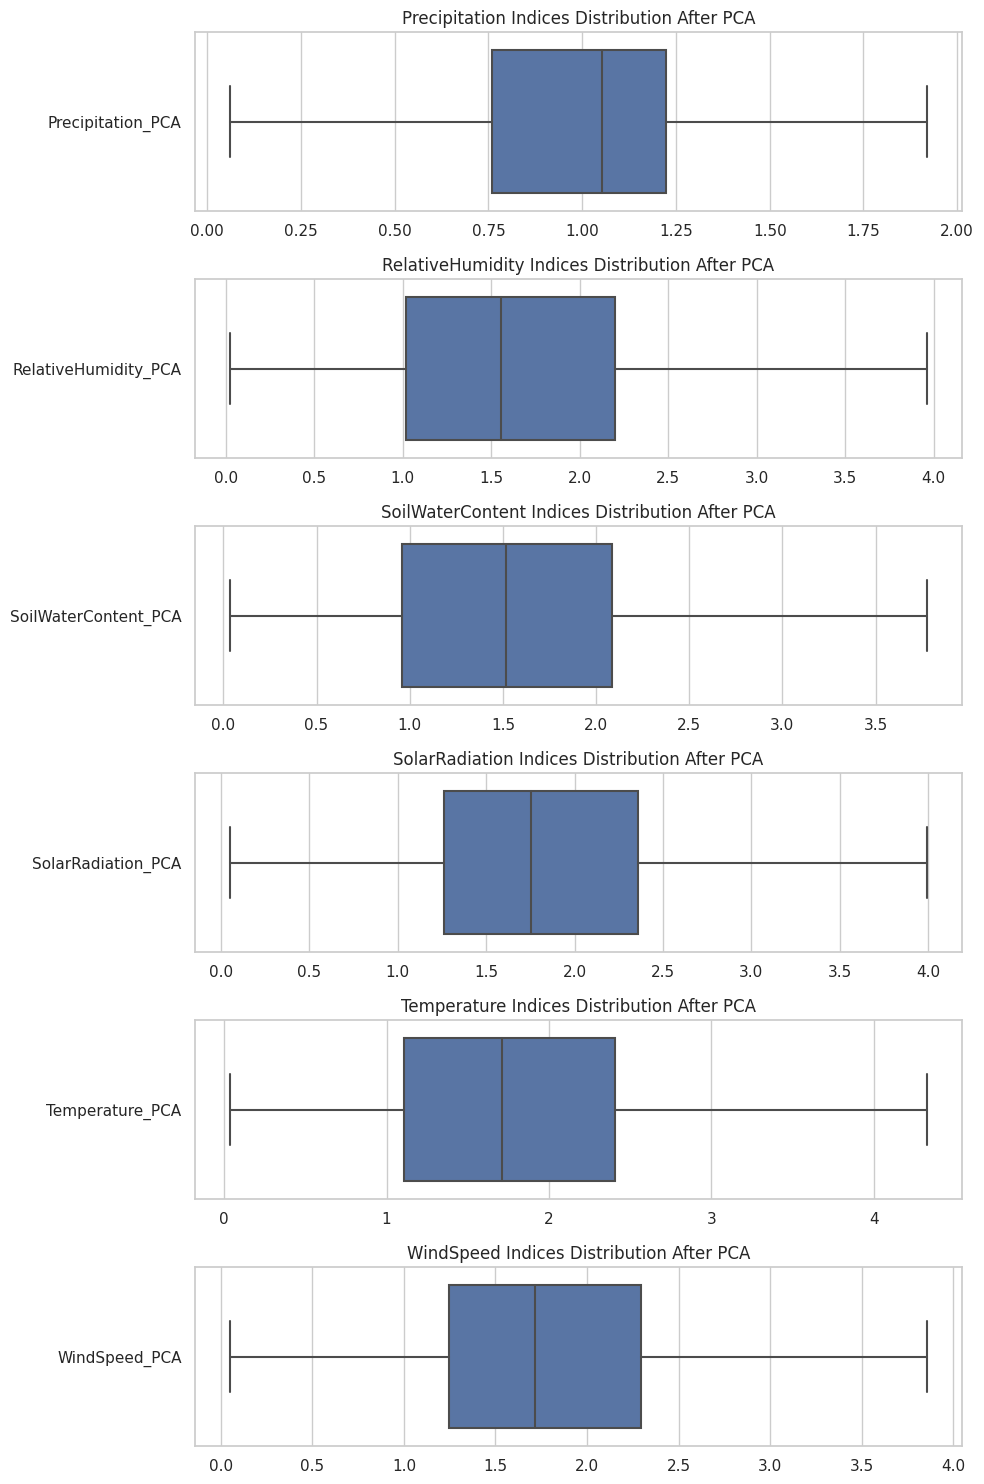

In [ ]:
# Plot PCA
sns.set(style="whitegrid")

attributes = ['Precipitation', 'RelativeHumidity', 'SoilWaterContent', 'SolarRadiation', 'Temperature', 'WindSpeed']

# Create a figure and set of subplots
fig, axes = plt.subplots(nrows=len(attributes), figsize=(10, 15))

# Loop through attributes and create a boxplot for each
for i, attr in enumerate(attributes):
    cols_to_plot = [col for col in df.columns if attr in col]
    data_to_plot = df[cols_to_plot]

    # Plot the boxplot
    sns.boxplot(data=data_to_plot, ax=axes[i], orient='h', showfliers=False)
    axes[i].set_title(f"{attr} Indices Distribution After PCA")

plt.tight_layout()
plt.show()

In [ ]:
df.drop('Date', axis=1, inplace=True)

In [ ]:
# from google.colab import files
# filename = 'predictionDataset.csv'
# df.to_csv(filename, index=False)

# files.download(filename)